In [1]:
#standard imports
import numpy as np
import pandas as pd
import math
import scipy
from scipy.interpolate import interp1d
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd
from os import listdir
#from PIL import Image
from skimage import io
%matplotlib inline

#change default plot settings
default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [1.5*val for val in default_figsize]
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 24}

mpl.rc('font', **font)
mpl.rc('axes', linewidth=3)

#Constants
pi = math.pi
heV = 4.14e-15 #eV*s
c = 2.99792e8 #m/s
kbeV = 8.6173e-5 #eV/K
keV = 8.6173e-5 #eV/K
h = 6.626e-34
kb = 1.38065e-23
q = 1.60218e-19
k = 1.3806488e-23
T = 293

In [2]:
#Specify Directory
directory = '2018_8-14Ld'

#Get all files in directory
names = []
for file in listdir(directory):
    names.append(file)

data = []        
for name in names:
    a = np.loadtxt(directory + '/' + name)
    data.append(a)

In [3]:
#First develop a filter to remove noise from Ld data. 
#Extra noise can occur do to Linkam stage heating element
def ld_noise_filter(data_times,data_in):    
    #Create stdev vector from data
    
    #params (can be tuned if giving bad performance)
    std_k = 5 #range to determine stdev
    elim_precentile = 70 #percentile to eliminate
    med_filt_kernel = 15 #kernel for median filter smoothing

    data_std = np.zeros(len(data_in))
    for jj in range(len(data_in)):
        #deal with beginning and end
        if jj < (std_k-1)/2:
            data_std[jj] = np.std(data_in[:std_k-1])/data_in[jj]
        elif jj >= (len(data_in) - (std_k-1)/2):
            data_std[jj] = np.std(data_in[-std_k:])/data_in[jj]
        else:
            data_std[jj] = np.std(data_in[int(jj-(std_k-1)/2):int(jj+(std_k-1)/2)])/data_in[jj]

    elim_thresh = np.percentile(abs(data_std),elim_precentile)
    elim_idx = []
    for jj in range(len(data_in)):
        if abs(data_std[jj]) > elim_thresh:
            elim_idx.append(jj)

    times_out = np.delete(data_times,elim_idx)
    data_out = np.delete(data_in,elim_idx)

    #now use median filter to smooth actual noise
    data_out = scipy.signal.medfilt(data_out,kernel_size=med_filt_kernel)

    return (times_out,data_out)

In [4]:
names

['2018_8-14_FAGACs_1p25PEAI_2pt_10V_Ld',
 '2018_8-14_FAGACs_2p5PEAI_2pt_20V_Ld',
 '2018_8-14_FAGACs_2p5PEAI_2pt_20V_Ld_8hrairstability',
 '2018_8-14_FAGACs_2p5PEAI_2pt_20V_Ld_air_after14hrillumination',
 '2018_8-14_FAGACs_2pt_10V_Ld',
 '2018_8-14_FAGACs_p625PEAI_2pt_10V_Ld']

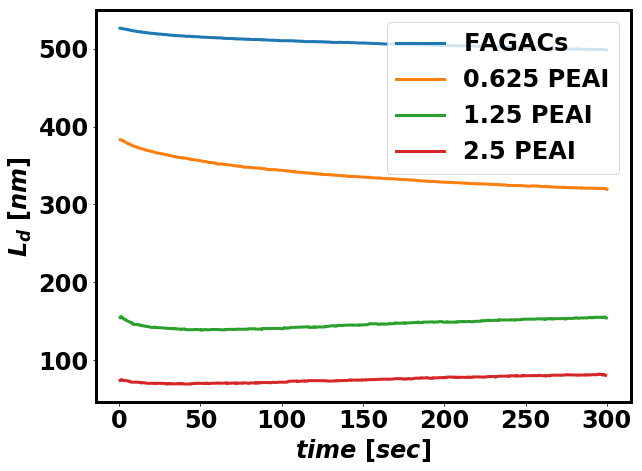

In [5]:
#Now calculate Ld and plot
times_list = []
Lds_list = []

#Note: d cancels out, but aI should be adjusted
d = 3e-7 #m
aI = 1.55e21 #photons/sec-m^2
    
for ii in (4,5,0,1):
    data_times = data[ii][:,0]
    data_in = data[ii][:,2]/data[ii][:,1]

    (times_out,data_out) = ld_noise_filter(data_times,data_in)
    
    sigma = 3*data_out/d #S/m
    Ld = np.sqrt(sigma*keV*T*q/(2*q**2*aI/d))
     
    times_list.append(times_out)
    Lds_list.append(Ld)
    
    plt.plot(times_out,Ld*1e9,linewidth=3)

plt.xlabel('$time\ [sec]$')
plt.ylabel('$L_d\ [nm]$')
#plt.ylim(-20,5)
#plt.xlim(0,1.2)
plt.legend(['FAGACs','0.625 PEAI','1.25 PEAI','2.5 PEAI']) 

In [6]:
#Now extract PLQY from widefield images and plot
#Specify Directory
directory_WF = '2018_8-14WF'

#Get all files in directory
names_WF = []
for file in listdir(directory_WF):
    names_WF.append(file)

names_WF

['2018_8-14 FAGACs_1p25PEAI_PLLd_Cube3_M5x_G46_ND25_50ms_1',
 '2018_8-14 FAGACs_2p5PEAI_PLLd_Cube3_M5x_G46_ND25_25ms_1',
 '2018_8-14 FAGACs_2p5PEAI_PLLd_Cube3_M5x_G46_ND25_25ms_air51p2RH_1',
 '2018_8-14 FAGACs_p625PEAI_PLLd_Cube3_M5x_G46_ND25_50ms_1',
 '2018_8-14 FAGACs_PLLd_Cube3_M5x_G46_ND25_100ms_1']

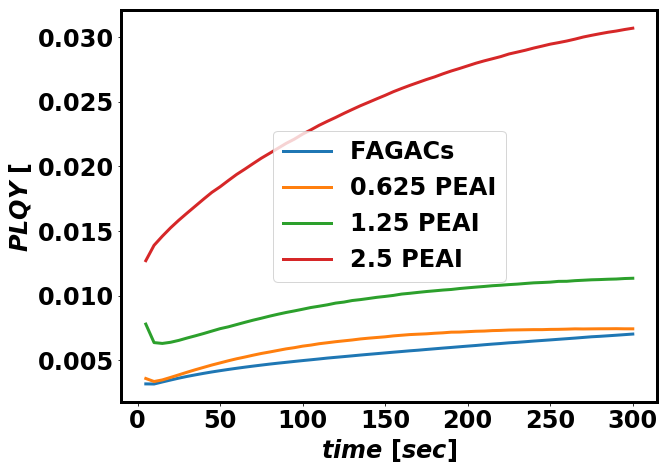

In [16]:
#im = Image.open(directory_WF + '/' + names_WF[4] + '/' + names_WF[4] + '_MMStack_Pos0.ome.tif')

#replace this with robust inference from metadata
WF_times = np.linspace(5,300,60) #times in sec
PLQYs_list = []

for ii in (4,3,0,1):
    im = io.imread(directory_WF + '/' + names_WF[ii] + '/' + names_WF[ii] + '_MMStack_Pos0.ome.tif')
    data_WF = np.array(im)

    pix_size = 1.45e-6 #m
    #better to replace this with metadata parsing, need to load metatdata
    idxms = names_WF[ii].find('ms_')
    exp_str = names_WF[ii][idxms-3:idxms]
    if exp_str[0] == '_':
        exp_str = exp_str[1:]

    exp_time = float(exp_str)/1000 #sec

    Excitation_flux = aI #photons/sec-m^2

    #calibration, needs to be adjusted
    calibration_numbers = 150*0.46*5.84*(0.038133877331141923/0.37277650051794803)

    PLQY_ims = np.float64(data_WF)/(pix_size**2*exp_time)/Excitation_flux

    """
    Z = PLQY_ims[0,250:1800,250:1800]*100
    plt.imshow(Z,cmap=cm.hot,interpolation='none')
    cbar = plt.colorbar()

    #vmin=1.08, vmax=1.2
    """
    PLQYs = np.zeros(PLQY_ims.shape[0])
    for tt in range(PLQY_ims.shape[0]):
        PLQYs[tt] = np.mean(PLQY_ims[tt,250:1800,250:1800]*100)

    PLQYs_list.append(PLQYs)
    plt.plot(WF_times,PLQYs,linewidth=3)
plt.xlabel('$time\ [sec]$')
plt.ylabel('$PLQY\ [\%]$')
#plt.ylim(-20,5)
#plt.xlim(0,1.2)
plt.legend(['FAGACs','0.625 PEAI','1.25 PEAI','2.5 PEAI']) 

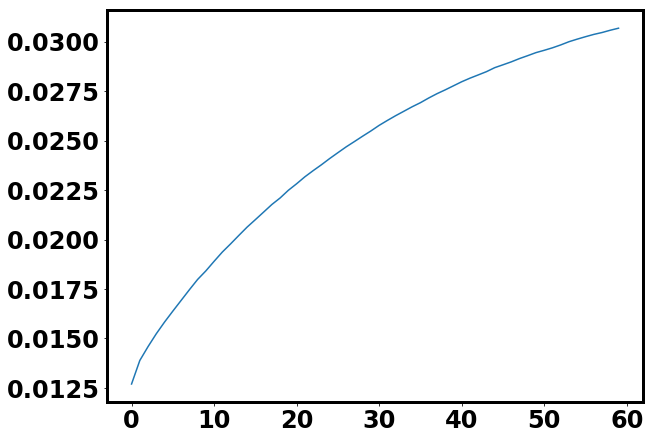

In [12]:
PLQYs = np.zeros(PLQY_ims.shape[0])
for tt in range(PLQY_ims.shape[0]):
    PLQYs[tt] = np.mean(PLQY_ims[tt,250:1800,250:1800]*100)

plt.plot(PLQYs)

In [15]:
ii

30

In [16]:
d = 3e-7 #m
aI = 1.55e21 #photons/sec-m^2
sigma = 1.16e-3 #S/m
Ld = math.sqrt(sigma*keV*T*q/(2*q**2*aI/d))
Ld

1.330063998832462e-07

In [ ]:
2018_8-14 FAGACs_PLLd_Cube3_M5x_G46_ND25_100ms_1_MMStack_Pos0_metadata

In [85]:
data = np.array(im)

In [87]:
data.shape

(2048, 2048)

In [23]:
Ld = math.sqrt(sigma*keV*T*q/(2*q**2*aI/d))
Ld

7.810404733630026e-08